In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, TimeDistributed

In [2]:
data = yf.download('SPY', start='2015-12-01', end='2018-01-31')
data = data[['Close']]  # Keep only 'Close' prices

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [4]:
# Fit ARIMA(1,1,1)
arima_model = ARIMA(data['Close'], order=(1, 1, 1))
arima_results = arima_model.fit()

# Predict on test data
arima_predictions = arima_results.predict(start=len(train_data), end=len(data)-1, typ='levels')
test_data['ARIMA_Predictions'] = arima_predictions

# Calculate MAE
mae_arima = mean_absolute_error(test_data['Close'], test_data['ARIMA_Predictions'])
print(f"ARIMA MAE: {mae_arima:.4f}")

ARIMA MAE: 0.7290


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-4-eb19c7e2ba07>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [8]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences with window=20
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split data
X_train, y_train = X[:train_size-seq_length], y[:train_size-seq_length]
X_test, y_test = X[train_size-seq_length:], y[train_size-seq_length:]

# Build LSTM model (optimized architecture)
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

# Predictions
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
mae_lstm = mean_absolute_error(actual_prices, lstm_predictions)
print(f"LSTM MAE: {mae_lstm:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0063
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.8581e-04
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 9.7393e-04
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.6375e-04
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 5.4782e-04
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.6906e-04
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.2879e-04
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.1015e-04
Epoch 9/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 4.0243e-04
Epoch 10/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.6594e-04


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
LSTM MAE: 1.0601


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0303 - val_loss: 0.0056
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 3.6593e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.1673e-04 - val_loss: 3.2575e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8593e-04 - val_loss: 1.4286e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4028e-04 - val_loss: 1.3605e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3507e-04 - val_loss: 2.4933e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2077e-04 - val_loss: 1.3510e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9659e-04 - val_loss: 1.8773e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0394e-04 - val_loss: 3.7498e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4961e-04 - val_loss: 1.6679e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1089e-04 - val_loss: 1.

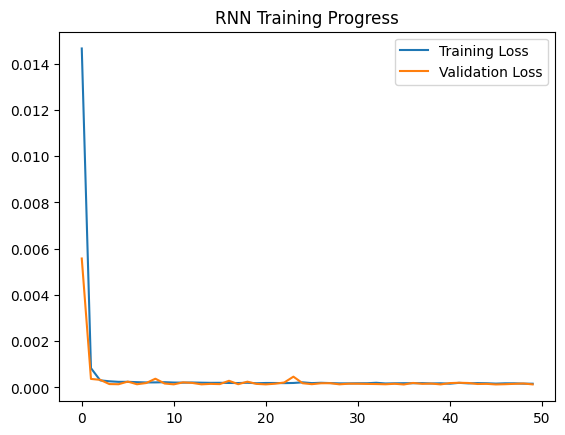

In [19]:
# Rebuild RNN correctly (Sequence-to-Vector)
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)),  # Only 1 RNN layer
    Dense(1)  # Single output
])
model_rnn.compile(optimizer='adam', loss='mse')

# Train longer with validation split
history = model_rnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# Predictions
rnn_predictions = model_rnn.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
mae_rnn = mean_absolute_error(actual_prices, rnn_predictions)
print(f"RNN MAE: {mae_rnn:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training Progress')
plt.legend()
plt.show()

In [20]:
# Calculate dynamic weights
weights = {
    'ARIMA': 1 / mae_arima,
    'LSTM': 1 / mae_lstm,
    'RNN': 1 / mae_rnn
}
total_weight = sum(weights.values())

# Normalize weights
for model in weights:
    weights[model] /= total_weight

print("\nModel Weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.2%}")

# Ensemble prediction
ensemble_pred = (
    weights['ARIMA'] * test_data['ARIMA_Predictions'].values[-len(actual_prices):] +
    weights['LSTM'] * lstm_predictions.flatten() +
    weights['RNN'] * rnn_predictions.flatten()
)

# Calculate final MAE
mae_ensemble = mean_absolute_error(actual_prices, ensemble_pred)
print(f"\nEnsemble MAE: {mae_ensemble:.4f}")


Model Weights:
ARIMA: 41.11%
LSTM: 28.27%
RNN: 30.61%

Ensemble MAE: 0.8502


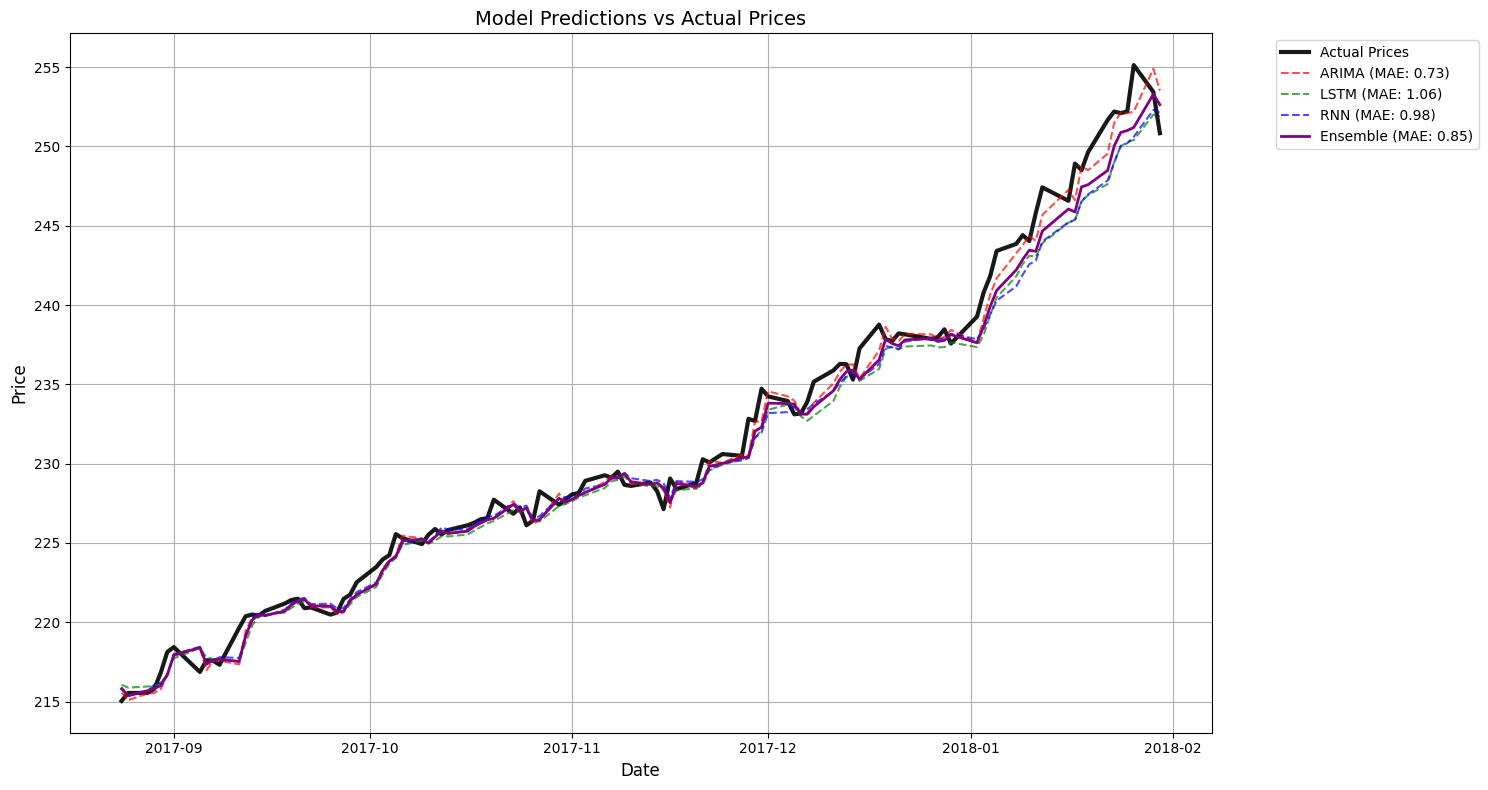

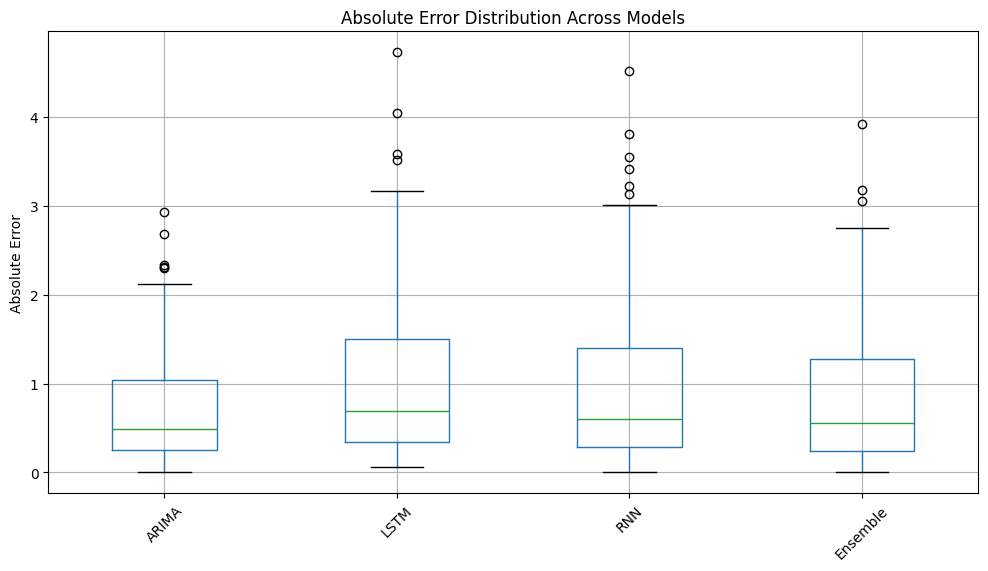

In [21]:
# 1. First ensure we have all predictions aligned properly
test_dates = test_data.index[-len(actual_prices):]
actual_values = actual_prices.flatten()

# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_values,
    'ARIMA': test_data['ARIMA_Predictions'].values[-len(actual_prices):],
    'LSTM': lstm_predictions.flatten(),
    'RNN': rnn_predictions.flatten(),
    'Ensemble': ensemble_pred
}).set_index('Date')

# 2. Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(results_df.index, results_df['Actual'], label='Actual Prices',
         color='black', linewidth=3, alpha=0.9)

# Plot individual models
models = ['ARIMA', 'LSTM', 'RNN']
colors = ['red', 'green', 'blue']
for model, color in zip(models, colors):
    plt.plot(results_df.index, results_df[model],
             label=f'{model} (MAE: {mean_absolute_error(results_df["Actual"], results_df[model]):.2f})',
             linestyle='--', alpha=0.7, color=color)

# Plot ensemble
plt.plot(results_df.index, results_df['Ensemble'],
         label=f'Ensemble (MAE: {mae_ensemble:.2f})',
         color='purple', linewidth=2)

plt.title('Model Predictions vs Actual Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Plot error distribution
errors = results_df.drop(columns='Actual').sub(results_df['Actual'], axis=0)
plt.figure(figsize=(12, 6))
errors.abs().boxplot()
plt.title('Absolute Error Distribution Across Models')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)
plt.show()